# Agent Evaluation

In [1]:
from openai import OpenAI
import pandas as pd
import json
import duckdb
from pydantic import BaseModel, Field
from IPython.display import Markdown

from helper import get_openai_api_key

In [2]:
# initialize the OpenAI client
openai_api_key = get_openai_api_key()
client = OpenAI(api_key=openai_api_key)

MODEL = "gpt-4o-mini"

In [3]:
# define the path to the transactional data
TRANSACTION_DATA_FILE_PATH = 'data/Store_Sales_Price_Elasticity_Promotions_Data.parquet'

In [4]:
# prompt template for step 2 of tool 1
SQL_GENERATION_PROMPT = """
Generate an SQL query based on a prompt. Do not reply with anything besides the SQL query.
The prompt is: {prompt}

The available columns are: {columns}
The table name is: {table_name}
"""

In [5]:
# code for step 2 of tool 1
def generate_sql_query(prompt: str, columns: list, table_name: str) -> str:
    """Generate an SQL query based on a prompt"""
    formatted_prompt = SQL_GENERATION_PROMPT.format(prompt=prompt, 
                                                    columns=columns, 
                                                    table_name=table_name)

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )
    
    return response.choices[0].message.content

In [6]:
# code for tool 1
def lookup_sales_data(prompt: str) -> str:
    """Implementation of sales data lookup from parquet file using SQL"""
    try:

        # define the table name
        table_name = "sales"
        
        # step 1: read the parquet file into a DuckDB table
        df = pd.read_parquet(TRANSACTION_DATA_FILE_PATH)
        duckdb.sql(f"CREATE TABLE IF NOT EXISTS {table_name} AS SELECT * FROM df")

        # step 2: generate the SQL code
        sql_query = generate_sql_query(prompt, df.columns, table_name)
        # clean the response to make sure it only includes the SQL code
        sql_query = sql_query.strip()
        sql_query = sql_query.replace("```sql", "").replace("```", "")
        
        # step 3: execute the SQL query
        result = duckdb.sql(sql_query).df()
        
        return result.to_string()
    except Exception as e:
        return f"Error accessing data: {str(e)}"

In [7]:
example_data = lookup_sales_data("Show me all the sales for store 1320 on November 1st, 2021")
print(example_data)

    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo
0           1320    6173050               22875 2021-11-01         1          4.990000         0
1           1320    6174250               22875 2021-11-01         1          0.890000         0
2           1320    6176200               22975 2021-11-01         2         99.980003         0
3           1320    6176800               22800 2021-11-01         1         14.970000         0
4           1320    6177250               22975 2021-11-01         1          6.890000         0
5           1320    6177300               22800 2021-11-01         1          9.990000         0
6           1320    6177350               22800 2021-11-01         2         16.980000         0
7           1320    6177700               22875 2021-11-01         1          3.190000         0
8           1320    6178000               22875 2021-11-01         2          6.380000         0
9           1320    6178250   

In [8]:
# Construct prompt based on analysis type and data subset
DATA_ANALYSIS_PROMPT = """
Analyze the following data: {data}
Your job is to answer the following question: {prompt}
"""

In [9]:
# code for tool 2
def analyze_sales_data(prompt: str, data: str) -> str:
    """Implementation of AI-powered sales data analysis"""
    formatted_prompt = DATA_ANALYSIS_PROMPT.format(data=data, prompt=prompt)

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )
    
    analysis = response.choices[0].message.content
    return analysis if analysis else "No analysis could be generated"

In [10]:
print(analyze_sales_data(prompt="what trends do you see in this data", 
                         data=example_data))

Analyzing the provided data reveals several trends and insights:

1. **Sales Volume**:
   - The quantity sold (Qty_Sold) for different SKUs varies, with some products being sold in larger quantities than others. For instance, SKU coded `6190050` sold 5 units while other SKUs sold fewer (most commonly 1 or 2). This indicates varying demand across products.

2. **Total Sales Value**:
   - There is a wide range in total sales values (Total_Sale_Value). Some products, like SKU `6176200` and `6184100`, are associated with higher sales values, likely due to higher prices or larger quantities sold. Price differentiation among SKUs is noticeable, suggesting different tiers of products (budget vs premium).

3. **Product Categories**:
   - The data contains a variety of product classes (indicated by Product_Class_Code). Certain product classes may have higher sales volumes and values, indicating that some classes may resonate better with consumers than others.

4. **Promotions**:
   - The "On_Pr

In [11]:
# prompt template for step 1 of tool 3
CHART_CONFIGURATION_PROMPT = """
Generate a chart configuration based on this data: {data}
The goal is to show: {visualization_goal}
"""

In [12]:
# class defining the response format of step 1 of tool 3
class VisualizationConfig(BaseModel):
    chart_type: str = Field(..., description="Type of chart to generate")
    x_axis: str = Field(..., description="Name of the x-axis column")
    y_axis: str = Field(..., description="Name of the y-axis column")
    title: str = Field(..., description="Title of the chart")

In [13]:
# code for step 1 of tool 3
def extract_chart_config(data: str, visualization_goal: str) -> dict:
    """Generate chart visualization configuration
    
    Args:
        data: String containing the data to visualize
        visualization_goal: Description of what the visualization should show
        
    Returns:
        Dictionary containing line chart configuration
    """
    formatted_prompt = CHART_CONFIGURATION_PROMPT.format(data=data,
                                                         visualization_goal=visualization_goal)
    
    response = client.beta.chat.completions.parse(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
        response_format=VisualizationConfig,
    )
    
    try:
        # Extract axis and title info from response
        content = response.choices[0].message.content
        
        # Return structured chart config
        return {
            "chart_type": content.chart_type,
            "x_axis": content.x_axis,
            "y_axis": content.y_axis,
            "title": content.title,
            "data": data
        }
    except Exception:
        return {
            "chart_type": "line", 
            "x_axis": "date",
            "y_axis": "value",
            "title": visualization_goal,
            "data": data
        }

In [17]:
# prompt template for step 2 of tool 3
CREATE_CHART_PROMPT = """
Write python code to create a chart based on the following configuration.
Only return the code, no other text.
config: {config}
"""

In [18]:
# code for step 2 of tool 3
def create_chart(config: dict) -> str:
    """Create a chart based on the configuration"""
    formatted_prompt = CREATE_CHART_PROMPT.format(config=config)
    
    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )
    
    code = response.choices[0].message.content
    code = code.replace("```python", "").replace("```", "")
    code = code.strip()
    
    return code

In [19]:
# code for tool 3
def generate_visualization(data: str, visualization_goal: str) -> str:
    """Generate a visualization based on the data and goal"""
    config = extract_chart_config(data, visualization_goal)
    code = create_chart(config)
    return code

In [20]:
code = generate_visualization(example_data, 
                              "A bar chart of sales by product SKU. Put the product SKU on the x-axis and the sales on the y-axis.")
print(code)

import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

data = """    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo
0           1320    6173050               22875 2021-11-01         1          4.990000         0
1           1320    6174250               22875 2021-11-01         1          0.890000         0
2           1320    6176200               22975 2021-11-01         2         99.980003         0
3           1320    6176800               22800 2021-11-01         1         14.970000         0
4           1320    6177250               22975 2021-11-01         1          6.890000         0
5           1320    6177300               22800 2021-11-01         1          9.990000         0
6           1320    6177350               22800 2021-11-01         2         16.980000         0
7           1320    6177700               22875 2021-11-01         1          3.190000         0
8           1320    6178000             

In [21]:
# Define tools/functions that can be called by the model
tools = [
    {
        "type": "function",
        "function": {
            "name": "lookup_sales_data",
            "description": "Look up data from Store Sales Price Elasticity Promotions dataset",
            "parameters": {
                "type": "object",
                "properties": {
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "analyze_sales_data", 
            "description": "Analyze sales data to extract insights",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["data", "prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "generate_visualization",
            "description": "Generate Python code to create data visualizations",
            "parameters": {
                "type": "object", 
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "visualization_goal": {"type": "string", "description": "The goal of the visualization."}
                },
                "required": ["data", "visualization_goal"]
            }
        }
    }
]

# Dictionary mapping function names to their implementations
tool_implementations = {
    "lookup_sales_data": lookup_sales_data,
    "analyze_sales_data": analyze_sales_data, 
    "generate_visualization": generate_visualization
}

In [22]:
# code for executing the tools returned in the model's response
def handle_tool_calls(tool_calls, messages):
    
    for tool_call in tool_calls:   
        function = tool_implementations[tool_call.function.name]
        function_args = json.loads(tool_call.function.arguments)
        result = function(**function_args)
        messages.append({"role": "tool", "content": result, "tool_call_id": tool_call.id})
        
    return messages

In [23]:
SYSTEM_PROMPT = """
You are a helpful assistant that can answer questions about the Store Sales Price Elasticity Promotions dataset.
"""

In [24]:
def run_agent(messages):
    print("Running agent with messages:", messages)

    if isinstance(messages, str):
        messages = [{"role": "user", "content": messages}]
        
    # Check and add system prompt if needed
    if not any(
            isinstance(message, dict) and message.get("role") == "system" for message in messages
        ):
            system_prompt = {"role": "system", "content": SYSTEM_PROMPT}
            messages.append(system_prompt)

    while True:
        print("Making router call to OpenAI")
        response = client.chat.completions.create(
            model=MODEL,
            messages=messages,
            tools=tools,
        )
        messages.append(response.choices[0].message)
        tool_calls = response.choices[0].message.tool_calls
        print("Received response with tool calls:", bool(tool_calls))

        # if the model decides to call function(s), call handle_tool_calls
        if tool_calls:
            print("Processing tool calls")
            messages = handle_tool_calls(tool_calls, messages)
        else:
            print("No tool calls, returning final response")
            return response.choices[0].message.content

In [25]:
result = run_agent('Show me the code for graph of sales by store in Nov 2021, and tell me what trends you see.')

Running agent with messages: Show me the code for graph of sales by store in Nov 2021, and tell me what trends you see.
Making router call to OpenAI
Received response with tool calls: True
Processing tool calls
Making router call to OpenAI
Received response with tool calls: True
Processing tool calls
Making router call to OpenAI
Received response with tool calls: True
Processing tool calls
Making router call to OpenAI
Received response with tool calls: False
No tool calls, returning final response


In [26]:
Markdown(result)

Here is the code used to create a graph of total sales value by store number for November 2021:

```python
import matplotlib.pyplot as plt
import pandas as pd
import ast

data = [{'Store_Number': 1980, 'Total_Qty_Sold': 893.0, 'Total_Sale_Value': 9084.959929},
        {'Store_Number': 2750, 'Total_Qty_Sold': 1462.0, 'Total_Sale_Value': 16310.409961},
        {'Store_Number': 1650, 'Total_Qty_Sold': 1770.0, 'Total_Sale_Value': 23186.909958},
        {'Store_Number': 4180, 'Total_Qty_Sold': 913.0, 'Total_Sale_Value': 10213.81992},
        {'Store_Number': 550, 'Total_Qty_Sold': 764.0, 'Total_Sale_Value': 9554.049975},
        {'Store_Number': 330, 'Total_Qty_Sold': 1105.0, 'Total_Sale_Value': 12569.599911},
        {'Store_Number': 1210, 'Total_Qty_Sold': 1821.0, 'Total_Sale_Value': 21021.669984},
        {'Store_Number': 1760, 'Total_Qty_Sold': 1207.0, 'Total_Sale_Value': 14598.209948},
        {'Store_Number': 660, 'Total_Qty_Sold': 1208.0, 'Total_Sale_Value': 13041.239901},
        {'Store_Number': 770, 'Total_Qty_Sold': 973.0, 'Total_Sale_Value': 9181.769959},
        {'Store_Number': 2420, 'Total_Qty_Sold': 1370.0, 'Total_Sale_Value': 15234.709888},
        {'Store_Number': 880, 'Total_Qty_Sold': 1525.0, 'Total_Sale_Value': 17753.769956},
        {'Store_Number': 3740, 'Total_Qty_Sold': 949.0, 'Total_Sale_Value': 10719.049952},
        {'Store_Number': 3410, 'Total_Qty_Sold': 1345.0, 'Total_Sale_Value': 15982.159946},
        {'Store_Number': 1320, 'Total_Qty_Sold': 1701.0, 'Total_Sale_Value': 19553.789981},
        {'Store_Number': 1540, 'Total_Qty_Sold': 1801.0, 'Total_Sale_Value': 21207.689942},
        {'Store_Number': 4730, 'Total_Qty_Sold': 819.0, 'Total_Sale_Value': 10571.779962},
        {'Store_Number': 2310, 'Total_Qty_Sold': 1594.0, 'Total_Sale_Value': 16611.539945},
        {'Store_Number': 2200, 'Total_Qty_Sold': 1513.0, 'Total_Sale_Value': 16854.439921},
        {'Store_Number': 1870, 'Total_Qty_Sold': 1648.0, 'Total_Sale_Value': 17091.849894},
        {'Store_Number': 3630, 'Total_Qty_Sold': 1311.0, 'Total_Sale_Value': 14202.299958},
        {'Store_Number': 1100, 'Total_Qty_Sold': 1712.0, 'Total_Sale_Value': 19298.679917},
        {'Store_Number': 3190, 'Total_Qty_Sold': 1003.0, 'Total_Sale_Value': 11934.999961},
        {'Store_Number': 990, 'Total_Qty_Sold': 1280.0, 'Total_Sale_Value': 15101.459945},
        {'Store_Number': 3300, 'Total_Qty_Sold': 1859.0, 'Total_Sale_Value': 23730.719905},
        {'Store_Number': 3080, 'Total_Qty_Sold': 1454.0, 'Total_Sale_Value': 18044.450005},
        {'Store_Number': 4840, 'Total_Qty_Sold': 1612.0, 'Total_Sale_Value': 19127.169971},
        {'Store_Number': 2090, 'Total_Qty_Sold': 1080.0, 'Total_Sale_Value': 11617.179888},
        {'Store_Number': 4070, 'Total_Qty_Sold': 932.0, 'Total_Sale_Value': 9161.409921},
        {'Store_Number': 2640, 'Total_Qty_Sold': 1005.0, 'Total_Sale_Value': 10891.639931},
        {'Store_Number': 2970, 'Total_Qty_Sold': 2312.0, 'Total_Sale_Value': 31000.569969},
        {'Store_Number': 2530, 'Total_Qty_Sold': 890.0, 'Total_Sale_Value': 11139.740003},
        {'Store_Number': 4400, 'Total_Qty_Sold': 225.0, 'Total_Sale_Value': 4390.689987}]

df = pd.DataFrame(data)

plt.figure(figsize=(10, 5))
plt.plot(df['Store_Number'], df['Total_Sale_Value'], marker='o')
plt.title('Total Sale Value by Store Number for November 2021')
plt.xlabel('Store Number')
plt.ylabel('Total Sale Value')
plt.xticks(df['Store_Number'], rotation=45)
plt.grid()
plt.tight_layout()
plt.show()
```

### Observations from the Sales Data:
1. **Total Units Sold**: The stores collectively sold a total of about 88372 units, indicating a high level of demand across various locations.

2. **Highest Sales Value**: Store 2970 had the highest sales value at approximately $31,000 and the highest quantity sold with 2312 units, signifying a strong sales performance.

3. **Lowest Sales Value**: Store 4400 reported the lowest sales value at around $4,390, indicating potential areas for improvement in sales strategies.

4. **Sales Performance Analysis**: There seems to be variation in sales performance across the stores, highlighting the need to analyze why certain stores are performing better than others, possibly looking at product offerings, pricing strategies or location characteristics.

5. **Volume vs. Value**: Some stores managed higher quantities sold but at lower total sales values, suggesting a focus on cheaper items. Others sold fewer items but with higher values, indicating a strategy focusing on premium products.

6. **Strategic Insights**: High-performing stores could serve as benchmarks for marketing and sales strategies, while underperforming stores might require targeted marketing, assessment of product offerings, or price adjustments to improve performance.

These insights can guide future strategies to enhance sales across all stores.

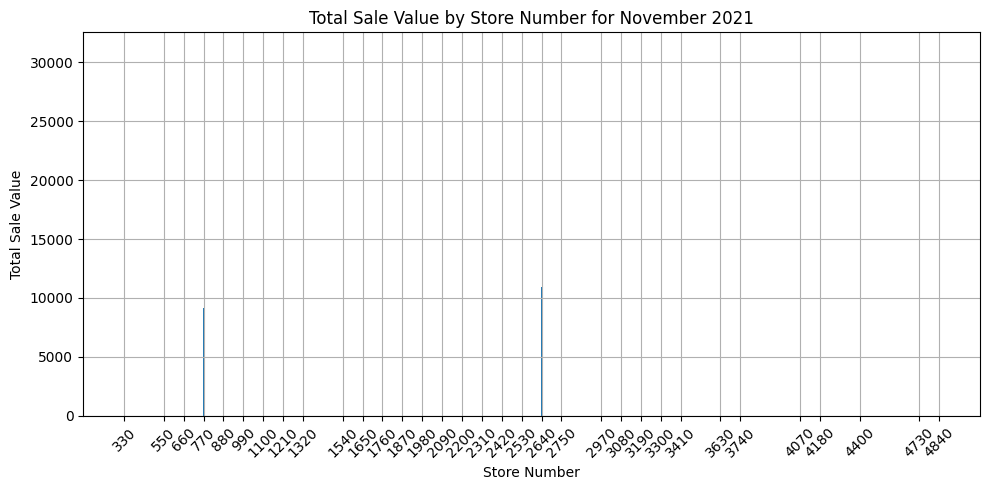

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import ast

data = [{'Store_Number': 1980, 'Total_Qty_Sold': 893.0, 'Total_Sale_Value': 9084.959929},
        {'Store_Number': 2750, 'Total_Qty_Sold': 1462.0, 'Total_Sale_Value': 16310.409961},
        {'Store_Number': 1650, 'Total_Qty_Sold': 1770.0, 'Total_Sale_Value': 23186.909958},
        {'Store_Number': 4180, 'Total_Qty_Sold': 913.0, 'Total_Sale_Value': 10213.81992},
        {'Store_Number': 550, 'Total_Qty_Sold': 764.0, 'Total_Sale_Value': 9554.049975},
        {'Store_Number': 330, 'Total_Qty_Sold': 1105.0, 'Total_Sale_Value': 12569.599911},
        {'Store_Number': 1210, 'Total_Qty_Sold': 1821.0, 'Total_Sale_Value': 21021.669984},
        {'Store_Number': 1760, 'Total_Qty_Sold': 1207.0, 'Total_Sale_Value': 14598.209948},
        {'Store_Number': 660, 'Total_Qty_Sold': 1208.0, 'Total_Sale_Value': 13041.239901},
        {'Store_Number': 770, 'Total_Qty_Sold': 973.0, 'Total_Sale_Value': 9181.769959},
        {'Store_Number': 2420, 'Total_Qty_Sold': 1370.0, 'Total_Sale_Value': 15234.709888},
        {'Store_Number': 880, 'Total_Qty_Sold': 1525.0, 'Total_Sale_Value': 17753.769956},
        {'Store_Number': 3740, 'Total_Qty_Sold': 949.0, 'Total_Sale_Value': 10719.049952},
        {'Store_Number': 3410, 'Total_Qty_Sold': 1345.0, 'Total_Sale_Value': 15982.159946},
        {'Store_Number': 1320, 'Total_Qty_Sold': 1701.0, 'Total_Sale_Value': 19553.789981},
        {'Store_Number': 1540, 'Total_Qty_Sold': 1801.0, 'Total_Sale_Value': 21207.689942},
        {'Store_Number': 4730, 'Total_Qty_Sold': 819.0, 'Total_Sale_Value': 10571.779962},
        {'Store_Number': 2310, 'Total_Qty_Sold': 1594.0, 'Total_Sale_Value': 16611.539945},
        {'Store_Number': 2200, 'Total_Qty_Sold': 1513.0, 'Total_Sale_Value': 16854.439921},
        {'Store_Number': 1870, 'Total_Qty_Sold': 1648.0, 'Total_Sale_Value': 17091.849894},
        {'Store_Number': 3630, 'Total_Qty_Sold': 1311.0, 'Total_Sale_Value': 14202.299958},
        {'Store_Number': 1100, 'Total_Qty_Sold': 1712.0, 'Total_Sale_Value': 19298.679917},
        {'Store_Number': 3190, 'Total_Qty_Sold': 1003.0, 'Total_Sale_Value': 11934.999961},
        {'Store_Number': 990, 'Total_Qty_Sold': 1280.0, 'Total_Sale_Value': 15101.459945},
        {'Store_Number': 3300, 'Total_Qty_Sold': 1859.0, 'Total_Sale_Value': 23730.719905},
        {'Store_Number': 3080, 'Total_Qty_Sold': 1454.0, 'Total_Sale_Value': 18044.450005},
        {'Store_Number': 4840, 'Total_Qty_Sold': 1612.0, 'Total_Sale_Value': 19127.169971},
        {'Store_Number': 2090, 'Total_Qty_Sold': 1080.0, 'Total_Sale_Value': 11617.179888},
        {'Store_Number': 4070, 'Total_Qty_Sold': 932.0, 'Total_Sale_Value': 9161.409921},
        {'Store_Number': 2640, 'Total_Qty_Sold': 1005.0, 'Total_Sale_Value': 10891.639931},
        {'Store_Number': 2970, 'Total_Qty_Sold': 2312.0, 'Total_Sale_Value': 31000.569969},
        {'Store_Number': 2530, 'Total_Qty_Sold': 890.0, 'Total_Sale_Value': 11139.740003},
        {'Store_Number': 4400, 'Total_Qty_Sold': 225.0, 'Total_Sale_Value': 4390.689987}]

df = pd.DataFrame(data)

plt.figure(figsize=(10, 5))
plt.bar(df['Store_Number'], df['Total_Sale_Value'])
plt.title('Total Sale Value by Store Number for November 2021')
plt.xlabel('Store Number')
plt.ylabel('Total Sale Value')
plt.xticks(df['Store_Number'], rotation=45)
plt.grid()
plt.tight_layout()
plt.show()